# 13. 멀리 있지만 괜찮아

# 13-1. Dlib 얼굴 인식의 문제점

### Face detection, 얼마나 작고 빨라질 수 있을까?
face detection을 한차례 진행해봤다. 그때 Dlib 라이브러리를 이용해서 face landmark를 찾아내는것이었다.   
하지만 문제가 있었다. 얼굴을 제대로 Detect하지 않거나, 각도에 취약했다. 그리고 속도도 많이 느렸다.

### 작아지고 빨라지는 게 중요한 이유.
![](https://d3s0tskafalll9.cloudfront.net/media/images/GC-10-L-00.max-800x600.png)

인증수단으로 얼굴 인식이 보편적으로 사용되고 있다. 얼굴 인식을 위해 딥러닝 서버 구동이 필요한 모델을 활용할 수 있을까?

서버로 이미지를 보낸 후 처리하는 방식은 __네트워크 비용 + 서버 비용 + 인터넷 속도__ 등 고려하지 않을 수 없다. 네트워크 상황과 무관하게 항상 동작해야하는 핸드폰 인증 수단으로는 적합하지 않다. 그렇다면 edge device(=핸드폰)으로 이용하려면 어떻게 해야할까?

핸드폰에 모델을 올리려면 weight가 작은 모델이 관리에 유리하다. 하지만 이는 성능 하락을 야기하기 때문에 어떻게 보완할 수 있을까?

- [카카오 얼굴인식 관련 리서치](https://tech.kakaoenterprise.com/63)
- [네이버 얼굴검출 관련 오픈소스](https://github.com/clovaai/EXTD_Pytorch)

### 어떻게 빠르게 만들 수 있을까?
Face detection에서 많은 시간이 드는 sliding window를 버려야 빨라진다. 그래서 2-stage detection은 좋은 선택이 아니다.

연산의 병렬화가 가능해야 한다. 컴퓨터 GPU는 병렬화가 가능하지만 핸드폰도 가능할까?

안드로이드는 MLKit, 아이폰은 CoreML이라는 라이브러리를 통해 병렬화를 할 수 있다. 하지만 제한이 많기 때문에 TFLite라는 도구를 이용하여 훈련된 모델을 이용하기도 한다.

- [Core ML](https://developer.apple.com/documentation/coreml)
- [ios 11 machine learning for everyone](https://machinethink.net/blog/ios-11-machine-learning-for-everyone/)
- [ML kit](https://www.slideshare.net/inureyes/ml-kit-machine-learning-sdk)
- [TFLite](https://www.tensorflow.org/lite?hl=ko)

다른 방법도 있다. 직접 병렬프로그래밍 라이브러리를 만들 수도 있지만 난이도는 엄청 클것이다. 비교적 쉬운 방법으로 병렬화 도구를 사용하는 방법이 있다.
- [SIMD-병렬-프로그래밍](https://stonzeteam.github.io/SIMD-%EB%B3%91%EB%A0%AC-%ED%94%84%EB%A1%9C%EA%B7%B8%EB%9E%98%EB%B0%8D/)
- [OpenCL](https://www.khronos.org/opencl/)
- [Android: Open GL ES](https://developer.android.com/guide/topics/graphics/opengl?hl=ko)

하지만 무엇보다 적은 파라미터로 정확한 성능을 가지는 모델을 설계하는게 중요하다. 이를 알아보자.

# 13-2. Single Stage Object Detection

2-Stage Detector는 정확도는 높지만 FPS가 느리다.   
왜냐하면 물체가 존재하는 bounding box를 먼저 localization한 후에 bounding box를 classification하는 두 가지 과정을 순차적으로 거치기 때문에 느리다.

얼굴 인식같은 딥러닝 모델이 가벼워야하는 task는 1-Stage 기반을 사용하는게 유리하다. localization과 classification을 동시에 수행한다. 그래서 속도가 빠르지만 정확도가 낮다는 단점도 있다.

![](https://d3s0tskafalll9.cloudfront.net/media/images/seukeurinsyas_2021-11-02_17-03-32.max-800x600.png)

# 13-3. YOLO(1) YOLO v1 등장

### YOLO: You Only Look Once
YOLO하면 빼놓을 수 없는 한 사람이 있다. Joseph Redmon, 즉 YOLO 논문의 1 저자이자 C로 구현된 오픈소스 뉴럴 네트워크 Darknet의 제작자이다.

### YOLO v1
YOLO의 출현은 당시 전 세계 computer vision 학계와 업계에 충격적인 기술 진보를 보여주었다. 
- [YOLO real time youtube](https://youtu.be/NM6lrxy0bxs)   
2분 15초부터 보면 된다.

2016년도 CVPR oral session에서 실시간 데모를 했다. 큰 서버도 없이 실시간으로 돌아가는 detection은 충격적으로 다가왔다.

# 13-4. YOLO(2) YOLO v1의 원리

### YOLO의 특징
1. You Only Look Once   
전체 이미지를 보는 횟수가 1이다. YOLO는 클래스에 대한 정보와 주변 정보까지 한번에 학습하고 처리한다. 그래서 배경 오류가 적고 일반화 성능이 좋다.
2. Unified   
Localization과 Classification을 동시에 수행한다. YOLO는 이미지를 신경망에 넣어주기만 하면 바로 detection이 가능하다.
3. Real-Time   
기본 YOLO는 45FPS, 빠른 버전은 150FPS까지 성능을 보인다.(Fast R-CNN은 0.5FPS, DPM은 30FPS의 성능을 갖고있다.) 그래서 스트리밍 비디오에서 실시간으로 객체를 detection 할 수 있다.

그리고 object detection을 회귀 문제로 관점을 전황했고, 여러 도메인에서 object detection이 가능하다는 특징이 있다.

### RCNN과 YOLO
![](https://d3s0tskafalll9.cloudfront.net/media/images/seukeurinsyas_2021-11-03_11-03-35.max-800x600.png)

대표적인 1, 2-stage detector인 RCNN과 YOLO의 특징을 확인해보자.

- RCNN   
객체가 존재할 것 같은 곳을 backbone network로 표현할 수 있다. -> Region Proposal Network(RPN)
- YOLO v1   
이미지 내의 작은 영역을 나누면 그곳에 객체가 있을 수 있다 -> grid 내에 객체가 존재한다.

YOLO v1의 grid는 고정되고, 그 grid 안에 객체가 있을 확률이 중요하게 된다.

### YOLO의 grid cell
YOLO는 이미지를 SxS grid로 나누고, box regression 단계와 각 클래스마다 probability map을 구하는 단계가 동시에 병렬적으로 수행된다.

논문에서는 입력 이미지를 7x7 grid로 나누고, 각 grid cell마다 예측하는 bbox를 2개, 총 클래스 수는 20으로 정했다.   
각 grid cell은 bbox와 C개의 class 확률을 예측한다.   
bounding box(bbox, B)는 x, y, w, h, confidence score를 예측한다.   
x, y는 bbox의 중심 좌표, w, h는 너비와 높이가 된다. 주의할 점은 w, h는 입력 이미지를 bbox의 너비와 높이를 나눠 normalize한 값으로, 0과 1사이의 값을 가진다.

confidence score는 box가 객체를 포함하고 있는지 모델이 얼마나 자신 있는지, 박스가 예측하는 것이 얼마나 정확한지 보여준다. 식으로 나타내면 아래와 같다.   
$P(Object)*IoU_{pred}^{truth}$

만약 grid cell이 객체를 포함하지 않으면 $P(Object)$ 값이 0이므로 confidence score는 0이 된다. grid cell이 객체를 정확히 포함하고 있다면 $P(Object)$는 1이므로 결국 IoU만 남게 된다. 따라서 confidence score가 예측된 box와 ground truth box 사이의 IoU와 같도록 하는것이 좋다.

C개의 조건부 클래스 확률 $P(Class_i|Object)$는 grid cell이 사물을 포함할 때 bbox안에 객체가 i번째 클래스에 속할 확률이다. bounding box의 개수와 상관 없이 각 grid cell의 확률만 예측한다.

![](https://d3s0tskafalll9.cloudfront.net/media/images/seukeurinsyas_2021-11-05_11-44-14.max-800x600.png)

예를들어 7x7 grid에서 grid당 2개의 bbox와 20개의 클래스를 예측하는 YOLO를 output tensor의 크기와 이를 flatten 했을 때 크기를 계산해보면 다음과 같다.   
$7*7(5*2+20)$   
이를 풀어서 보면 7x7 사이즈의 그리드가 있고 한 그리드 안에 2개의 박스를 갖고 있고 bbox 하나당 5개의 정보를 갖고 있으며 20개의 클래스를 예측한 값을 담고 있다.

위 그림에서 자전거를 포함하는 grid가 많이 있다. 동일한 객체를 잡는 bbox가 많아지는 문제가 생긴다.   
이때 __NMS(Non Maximum Suppression)__ 같은 기법을 이용한다. 비 최대 억제라고 불리는 NMS 기법은 object detector가 예측한 여러 개의 bounding box중 정확한 bounding box만 선택하는 기법이다.   
알고리즘을 풀어서 살펴보자.   
- 하나의 클래스에 높은 confidence score 순서대로 bbox를 정렬한다. confidence score가 특정 threshold를 넘지 않으면 제거한다.
- 가장 높은 confidence score의 bbox와 겹치는 다른 bbox를 비교하여 IoU가 threshold보다 높으면 겹치는 bbox를 목록에서 제거한다. 두 bbox의 IoU가 높다는 것은 같은 객체를 detect하고 있다는 의미이기 때문이다.
- 위 과정을 반복해 마지막으로 남은 bbox를 반환한다.
- 각 클래스에 대해 위 과정을 반복한다.

![](https://d3s0tskafalll9.cloudfront.net/media/original_images/seukeurinsyas_2021-11-03_12-05-25.png)   
NMS를 적용했을 때 bounding box

YOLO의 목표는 grid에 포함되는 객체를 잘 잡아내는 것이다. grid cell에 속하는 객체를 검출할 책임이 있는것이다. 1개 grid에 귀속된 bbox 정보(x,y,w,h)의 학습 목표는 bbox의 ground truth와 최대한 동일하도록 학습되는 것이다. 학습 목표가 제대로 이루어졌는지 확인하기 위해 IoU를 사용한다.

### YOLO 네트워크 구조
![](https://d3s0tskafalll9.cloudfront.net/media/images/seukeurinsyas_2021-11-03_12-32-17_ESbpTAx.max-800x600.png)

24개의 Conv layer, 2개의 FC layer로 이루어져 있다.

모델 구조의 pretrained된 앞부분은 ImageNet의 1000개 클래스 데이터셋을 갖고 사전학습한 GoogLeNet 모델이다. 사전 학습을 위해 20개의 Conv 레이어와 average pooling 레이어와 fully connected 레이어를 사용했다. 그러나 GoogLeNet의 Inception 모듈 대신 1x1 reduction 레이어를 사용해 연산량을 감소시켰다.

detection을 위해 사전학습된 모델에 4개의 Conv 레이어와 2개의 FC 레이어를 추가했고, PASCAL VOC 데이터셋으로 fine tuning했다.   
fine grained 이미지를 얻기 위해 원래 224x224 이미지의 2배인 448x448의 이미지를 사용했다고 한다.

마지막 레이어는 Class 확률과 bbox 좌표를 학습하고 예측하여 SxSx(B*5+C) 크기의 텐서로 예측값이 출력된다.

### YOLO의 Inference 과정
![](https://d3s0tskafalll9.cloudfront.net/media/original_images/seukeurinsyas_2021-11-03_11-04-46.png)

Inference를 할 때는 조건부 클래스 확률 $P(Class_i|Object)$를 각 box의 confidence 예측값과 곱해 각 box의 클래스별 confidence score(class specific confidence score)를 얻을 수 있다.   
각 score는 box의 클래스의 확률과 예측된 box가 사물을 얼마나 예측하는지 보여준다.

$P(Class_i|Object)*P(Object)*IoU_{pred}^{truth} = P(Class_i)*IoU_{pred}^{truth}$

이 과정을 모든 bbox에서 시행하면 한 이미지에서 예측한 클래스별 confidence score 개수는 7x7x2=98개가 된다.   
98개의 클래스별 confidence score에 대해 20개의 class를 기준으로 NMS를 하여 object에 대한 class와 bounding box location을 결정할 수 있게 된다.

# 13-5. YOLO(3) YOLO v1의 성능

### YOLO v1의 loss 함수
YOLO의 loss는 bbox의 위치 예측과 관련된 localization loss와 클래스 예측과 관련된 classification loss가 있으며, 두 loss 모두 SSE(sum-squared error)를 기반으로 한다.   
그런데 두 SSE의 loss를 동일하게 가중치준다. 이 상황은 이상적이 아니다.   
뿐만 아니라 이미지 내 대부분의 grid cell에 객체가 없을 경우가 일반적인데, 이런 경우 confidence score가 0에 가깝게 된다. 이는 모델의 불균형을 초래한다.

이런 문제를 해결하기 위해 bbox 좌표에 대한 loss를 증가시키고, 객체가 없는 box의 confidence 예측값의 loss는 감소시켰다.   
이를 위해 $\lambda_{coord}$와 $\lambda_{noobj}$라는 두 개의 하이퍼파라미터를 사용했다.

뿐만 아니라 SSE는 큰 bbox와 작은 bbox의 loss를 모두 동일한 가중치고 계산한다. 그래서 작은 bbox가 큰 bbox보다 조그마한 위치 변화에 더 민감하다. 이를 개선하기 위해 bbox의 너비와 높이에 square root를 적용했다.   

YOLO의 loss 함수는 다음과 같다.

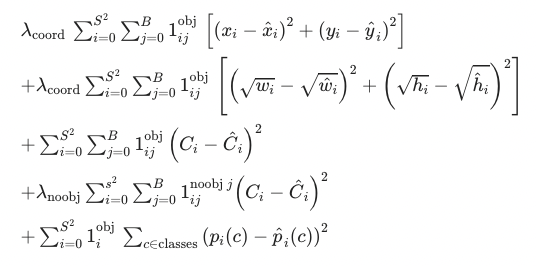

하나씩 살펴보자.   
- $1_i^{obj}$는 grid cell i안에 객체의 여부를 나타낸다. 있으면 1, 없으면 0을 출력한다.
- $1_{ij}^{obj}$는 객체가 존재하는 grid cell의 i의 j번째 bbox predictor이고, i번째 cell에 객체가 있고, j번째 predictor의 값이 다른 predictor보다 높으면 1, 그렇지 않으면 0으로 출력한다.
- $1_{ij}^{noobj}$는 객체가 존재하지 않는 grid cell의 j번째 bbox predictor를 의미한다.

- 첫번째 항 ~ 세번째 항: 객체가 존재하는 gird cell i의 bbox predictor j를 말한다.
    - 첫번째 항: x와 y의 loss 계산
    - 두번째 항: 너비와 높이의 loss 계산(제곱근을 취한 SSE)
    - 세번째 항: confidence score의 loss 계산
- 네번째 항: 객체가 존재하지 않는 grid cell i의 bbox predictor j에 대해 confidence score의 loss 계산(객체가 없을 때 패널티)
- 다섯번째 항: 객체가 존재하는 grid cell i에 대해 조건부 클래스 확률의 loss 계산

### YOLO의 성능
![](https://d3s0tskafalll9.cloudfront.net/media/original_images/seukeurinsyas_2021-11-03_16-57-08.png)

![](https://d3s0tskafalll9.cloudfront.net/media/images/seukeurinsyas_2021-11-03_17-00-17.max-800x600.png)

arXiv 논문 발표에서는 mAP가 63.4였지만 CVPR 2016 발표에서는 69.0으로 모델의 성능을 향상되어 발표했다. 즉 YOLO v1은 Faster R-CNN과 성능에 큰 차이가 나지 않으면서 속도는 6배 이상인 혁신적인 연구였음을 말한다.

### YOLO v1의 단점
YOLO v1도 단점이 있다. 각각 grid cell이 2개의 box와 하나의 클래스만 예측이 가능하므로 가까이에 있는 여러개의 객체를 예측하기 어려워했다. 특히 새때와 같이 그룹으로 나타나는 작은 object에 예측을 제대로 하지 못했다.

또한 bbox의 형태가 training data를 통해 학습되었기 때문에 bbox 분산이 너무 넓어 새로운 형태의 bbox 예측이 잘 안되기도 했다. 모델 구조상 backbone만 거친 feature map을 대상으로 bbox 정보를 예측하기 때문에 localization이 다소 부정확했다.

마지막으로 loss 함수가 작은 bbox와 큰 bbox의 loss를 같게 다루기 때문에 큰 box의 작은 loss보다 작은 box의 작은 loss가 IoU에 더 큰 영향을 미치게된다. 그래서 2017년 YOLO v2가 나오게 된다.

# 13-6. YOLO(4) YOLO v2
![](https://d3s0tskafalll9.cloudfront.net/media/images/GC-10-L-15.max-800x600.png)

Object Detection에 혁신을 가져온 Redmon은 1년 뒤 CVPR 2017에 YOLO v2를 가져왔다.   
발표자료에서 YOLO도 좋지만 정확도가 아쉬웠다고 언급한다.   
![](https://d3s0tskafalll9.cloudfront.net/media/images/GC-10-L-17.max-800x600.png)

![](https://d3s0tskafalll9.cloudfront.net/media/images/GC-10-L-18.max-800x600.png)   
위 사진은 CVPR 2016에서 데모중에 YOLO가 뒷문을 화장실로 인식해버리는 사고가 있었다. 그 장면을 캡쳐해서 가지고 나와 YOLO의 정확도가 낮다는 것을 보여줬다.

### YOLO v2의 목적
- make it better
- do it faster
- makes us stronger

요약하면 recall을 올리고 localization을 잘 해보자는 의미이다.

### Make it better
정확도를 올리기 위한 방법으로, YOLO v2는 이전 모델에서 낮은 성능으로 보인 localization과 recall을 높이면서 모델을 단순하게 만들고 속도도 빠르게 하려고했다.

![](https://d3s0tskafalll9.cloudfront.net/media/images/seukeurinsyas_2021-11-03_17-17-00.max-800x600.png)

이를 위해 위와 같은 방법을 사용했다.   
이렇게 사용한 방법들을 정리해보자.

__batch normalization__   
모든 conv 레이어에 batch norm을 사용했고, dropout은 제거했다.   
mAP에서 2% 성능 향상을 야기했다.

__high resolution classifier__   
YOLO v1에서 ImageNet의 224x224 이미지를 학습하고, detection에서 448x448 이미지를 사용한것과 달리 YOLO v2는 처음부터 448x448 해상도로 학습했다.   
mAP에서 4% 성능 향상을 야기했다.

__convolutional with anchor boxes__   
bounding box를 예측하기 위해 YOLO v1의 fully connected 레이어를 제거하고 fully convolutional network를 사용했고, anchor box를 사용해 bounding box를 예측했다.

또한 1개의 중앙점을 갖는 13x13(홀수x홀수)의 출력 feature map을 만들도록 입력 이미지의 크기를 448x448에서 416x416으로 줄였다.   
이는 대부분의 객체가 이미지의 중앙에 있는데, 중앙에 위치한 객체의 경우는 중앙점이 하나일 경우에 예측을 더 잘할것이라는 예상이 있었다.

따라서 YOLO v2는 13x13x5의 bounding box를 예측한다.   
그 결과 mAP는 69.5 -> 69.2로 줄어들지만 recall이 81% -> 88%로 증가했다.

__dimension cluster__   
Fast R-CNN에서 anchor box의 크기와 비율을 사전에 정해주고, 학습을 통해 세부 조정을 했다. 하지만 YOLO v2는 k-means clustering을 적용해 최적의 anchor box를 결정했다.

유클리드 거리를 사용하는 일반적인 k-means clustering과 달리 IoU 개념을 사용하는 distance matric으로 사용해 더 좋은 anchor box를 얻을 수 있었다.   
그 이유는 ground truth box와 유사한 IoU가 높은 anchor box를 찾기 위해서이다.

클러스터링 개수를 늘리면 정확도가 높아지지만 속도가 느려지므로 YOLO v2는 최종적으로 5개의 anchor box를 사용했다.

![](https://d3s0tskafalll9.cloudfront.net/media/original_images/seukeurinsyas_2021-11-03_18-00-10.png)

__direct location prediction__   
YOLO v2는 결정한 anchor box에 따라 하나의 셀에서 5차원의 벡터로 이루어진 bounding box를 조정하여 예측했다.   
학습 초반에 random initalization으로 인한 학습의 불안정을 예방하기 위해 bounding box가 grid cell을 벗어나지 않도록 제약을 둔거다.   
주의할 점은 YOLO v1이 grid cell의 중앙점을 예측했다면, YOLO v2는 좌상단으로부터 얼마나 이동했는지 예측한다.

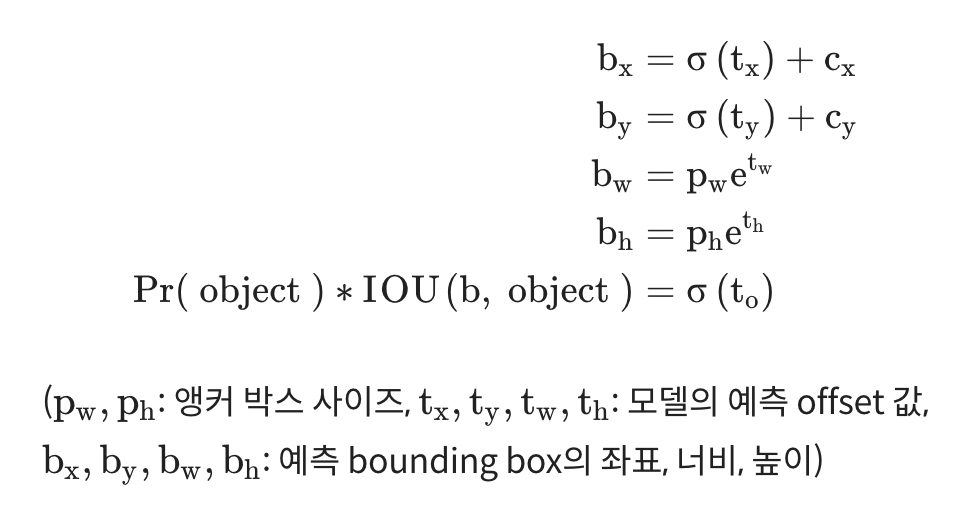

dimension cluster와 direct location prediction을 사용해 5% 성능 향상을 야기했다.   
![](https://d3s0tskafalll9.cloudfront.net/media/original_images/seukeurinsyas_2021-11-03_18-11-11.png)

__fine grained features__   
13x13의 feature map은 작은 물체 검출을 잘 하지 못하는 단점이 있었으므로, YOLO v2는 passingthrough 레이어를 사용했다. 이는 이전 레이어의 26x26 feature map과 13x13의 feature map을 concatenate한다.   
이렇게 하는 이유는 26x26의 feature map에 fine-grained features(고해상도 피처)가 담겨있기 때문이다.

그러나 두 feature map의 크기가 다르기 때문에 26x26x512 feature map을 13x13x2048 feature map으로 변환한 후 concatenate했다.   
이는 1% 성능 향상을 야기했다.

__multi scale training__   
모델이 다양한 입력 사이즈에 예측을 잘 할 수 있도록 매 10개의 batch마다 입력 이미지의 크기를 바꿔가며 모델 학습을 진행했다. 모델이 32 32간격으로 downsample 되므로 입력 이미지는 32의 배수가 될 수 있다.   
글서 입력 이미지의 크기는 320, 352, ... 608 중 하나가 사용된다.

### Do it faster
detection 속도를 향상시키기 위한 방법이다.

__Darknet-19__   
YOLO v2에서 fully connected layer를 제거하고 global average pooling을 하여 가중치 파라미터 수를 크게 줄였다.   
이렇게 만든 최종 모델을 darknet-19이라 불리는데, 19개의 convolutional 레이어와 5개의 maxpooling 레이어로 이루어져 있다.

DarkNet-19를 통과한 YOLO v2의 최종 출력은 13x13x125이다. feature map이 13x13이고, 5개의 bounding box를 예측하기 때문에 5*(5+20)으로 계산되어 13x13x125가 된다.   
(bounding box가 x,y,w,h, confidence를 예측하고 클래스 개수가 20이다)   
![](https://d3s0tskafalll9.cloudfront.net/media/original_images/seukeurinsyas_2021-11-05_14-45-08.png)

### Makes us stronger
stronger는 더 많은 범위의 class를 예측하기 위한 방법이다.   
YOLO v1은 PASCAL VOC 데이터셋에서 제공되는 20개의 클래스를 기준으로 학습해서 20개만 detection했다.   
YOLO v2에서는 9000개의 클래스에서 detection 할 수 있도록 하고, 모델을 YOLO9000이라 불렀다. 그래소 논문 이름도 YOLO9000이라 발표되었다.

YOLO 9000은 YOLO v2와 모델 구조가 같고 detection하는 라벨을 늘렸다. 간단히 설명하면 9천개의 클래스에 대해 분류를 하기 위해 계층적으로 분류작업(hierachical classification)을 수행하여 기존의 WordNet 기반의 데이터를 트리 구조인 WordTree를 생성했다.

![](https://d3s0tskafalll9.cloudfront.net/media/original_images/seukeurinsyas_2021-11-08_12-22-08.png)


ImageNet+COCO dataset+ImageNet Detection을 합쳐 9천개의 클래스 라벨을 생성했다.   
그 후 detection과 classification을 합쳐 학습을 하는데, detection 데이터셋과 classification 데이터셋의 개수 차이가 크기 때문에 oversampling 하여 detection과 classification 비율을 4:1로 맞췄다.   
detection 데이터셋은 classification과 bbox에 대산 loss를 역전파했지만 classification 데이터셋은 classification loss만 역전파하여 학습했다. 이로 인해 9천개의 클래스를 detection 할 수 있게 됐다.

### YOLO v2의 성능비교
![](https://d3s0tskafalll9.cloudfront.net/media/images/seukeurinsyas_2021-11-05_15-09-50.max-800x600.png)

mAP가 상승하고 FPS도 개선되었음을 확인할 수 있다. 하지만 여전히 mAP와 FPS의 trade off가 존재한다.

YOLO v2 발표 당시 SSD, R-FCN 등 이미 발표된 상황이었다. 특히 SSD, YOLO는 같은 single stage 방법을 지향하고 있어, 경쟁을 하고 있었고 YOLO v2 입장에서는 성능 차이를 부각시키는게 중요한 과제였다.

[TED YOLO v2 영상](https://www.ted.com/talks/joseph_redmon_how_computers_learn_to_recognize_objects_instantly?language=ko)

# 13-7. YOLO(5) YOLO v3
![](https://d3s0tskafalll9.cloudfront.net/media/original_images/GC-10-L-26.png)

### RetinaNet의 도발
RetinaNet의 figure 성능을 보면 YOLO v2를 언급하면서 figure에는 표시도 하지 않았다.

하지만 Redmon은 새로운 YOLO v3를 들고 RetinaNet과 비교를 하기 시작했다.   
![](https://d3s0tskafalll9.cloudfront.net/media/images/GC-10-L-27.max-800x600.png)

YOLO 프로젝트 페이지에도 그대로 사용했다.   
![](https://d3s0tskafalll9.cloudfront.net/media/images/GC-10-L-29.max-800x600.png)

### YOLO v3 원리
YOLO v2보다 조금 느리지만 정확도를 개선한 모델이다. 특히 YOLO의 약점인 작은 물체를 detection할 때 성능을 개선했다.

[YOLOv3: An Incremental Improvement](https://arxiv.org/abs/1804.02767) 논문이라기보다 Tech Report인데, 이전의 YOLO 모델과 차이점을 간략하게 소개한 보고서이다.   
YOLO v3는 v2에서 약간의 변화만 추가했다. 이 차이점을 중심으로 알아보자.

__Bounding Box Prediction__   
bounding box prediction은 YOLO v2와 거의 차이가 없다. 하지만 각각의 bounding box마다 objectness score, 즉 bbox에 물체가 있는지 예측하는 점수를 logistic regression을 사용해 예측했다.   
anchor box와 ground truth box의 IoU가 가장 높은 박스의 objectness score는 1로 두고 나머지는 무시했다. 또한 Faster R-CNN 등의 다른 모델과 달리 각각의 ground truth에 대해 1개의 bounding box만 갖게 된다는 차이가 있다.

![](https://d3s0tskafalll9.cloudfront.net/media/original_images/seukeurinsyas_2021-11-08_14-06-51.png)

__Class prediction__   
YOLO v3는 하나의 이미지에 다양한 label을 붙일 수 있는 multilabel classification을 했다.   
예를들어 여성의 이미지에 preson과 woman이라는 두 가지 label을 붙일 수 있음을 의미한다. 이를 위해 여러 개중 하나만 찾는 softmax classifier가 아닌 해당 label이 맞는지 아닌지를 판단하는 logistic classifier를 사용했고, binary cross entropy를 사용해 loss를 계산했다.

__Predictions Across Scales__   
YOLO v3는 3개의 scale로 bounding box를 예측했고, 각 scale당 3개의 bounding box를 예측했다. 따라서 총 9개의 bounding box가 나오며, 텐서는 NxNx3*(4+1+80)이 된다.   
3은 Anchor box, 4는 bounding box의 좌표, 너비, 높이, 1은 objectness score, 80은 클래스 수이다.

feature map을 2배씩 upsampling 하면서 더 의미있는 semantic information을 얻고, 이전 feature map과 concatenate하여 보다 fine-grained한 정보를 얻을 수 있었다고 한다.

__DarkNet-53__   
성능을 높이기 위해 YOLO v3는 53개의 레이어를 사용했다.   
YOLO v2의 아키텍처였던 DarkNet-19에 residual network를 넣어 레이어를 53개까지 쌓았다.   
![](https://d3s0tskafalll9.cloudfront.net/media/original_images/seukeurinsyas_2021-11-08_14-32-44.png)

![](https://d3s0tskafalll9.cloudfront.net/media/original_images/seukeurinsyas_2021-11-08_14-54-53.png)

DarkNet-53은 19보다 정확도가 높았고, ResNet-101이나 ResNet-152와 성능이 비슷하지만 연산에서 효율적이었다.

![](https://d3s0tskafalll9.cloudfront.net/media/images/seukeurinsyas_2021-11-08_14-41-33.max-800x600.png)

전체 모델 구조를 확인해볼 수 있다.   
입력 이미지를 DarkNet-53에 통과시켜 downsampling 하며 feautre map을 추출한다.   
추출한 feature map을 토대로 detection을 하고, upsampling 후 다시 detection하고 다시 upsampling을 한 후에 detection한다.   
3개의 scale된 bounding box를 이용한 detection을 적용하여 여러 개의 label에 대해서도 classification을 할 수 있게 됐다.

# 13-8. YOLO v3 그 이후

Redmon은 CV 연구가 자신의 목적과 다르게 군사적으로 사용되고 있음에 회의감을 느끼고 CV 연구를 그만두겠다 선언한다. 그래서 YOLO 등 DarkNet 프로젝트는 Alexey bochkovskiy가 메인테이너로 이어받게 됐다.

### YOLO v4
![](https://d3s0tskafalll9.cloudfront.net/media/original_images/seukeurinsyas_2021-11-08_15-15-12.png)

2020년 4월에 YOLO v4를 발표했다. YOLO v3보다 AP, FPS가 10, 12% 증가됐음을 볼 수 있다. 

YOLO v4를 간단히 설명하면 YOLO v3에 다양한 기법을 사용해 하나의 GPU로 object detection을 실시간으로 할 수 있도록 만든 모델이다.   
백본으로 CSPDarknet-53을 사용했고, Neck(feature map 정제 및 재구성)으로 SPP와 PAN, Head(object classification, localization)에서 YOLO v3를 사용했다.

YOLO v4 = YOLO v3 + CSPDarknet-53 + SPP + PAN(Path Aggregation Network) + BoF(Bag of Freebies) + Bos(Bag of Specials)

BoF는 Inference cost의 변화 없이 성능을 향상시키는 방법으로 전처리 또는 학습 단계에서 사용된다.   
data augmentation, regularization, loss function 등이 이 기법에 속한다.   
BoS는 inference cost가 조금 상승하면서 성능을 향상시키는 방법으로, inference 단계나 후처리 단계에서 사용된다.   
Enhance Receptive field, feature integration, activation function, attention module, normalization, post processing 등이 해당된다.

### YOLO v5
2020년 6월에 YOLO v3를 pytorch로 구현한 glenn jocher에 의해 발표됐다.   
YOLO v5는 처음으로 논문과 함께 발표되지 않은 최초의 모델이자, DarkNet이 아닌 PyTorch로 구현하여 기존 YOLO와 많이 달라 해당 이름에 논란이 있던 모델이다.   
YOLO v4와 성능은 비슷하지만 용량이 훨씬 작고 속도도 빠르다.

![](https://d3s0tskafalll9.cloudfront.net/media/original_images/seukeurinsyas_2021-11-08_16-23-29.png)   
![](https://d3s0tskafalll9.cloudfront.net/media/original_images/seukeurinsyas_2021-11-08_16-23-29.png)

YOLO v5는 4가지 버전이 있다.   
YOLOv5s, YOLOv5m, YOLOv5l, YOLOv5x로 각각 small, medium, large, xlarge로 백본이나 head는 동일하지만 모델 깊이와 레이어의 채널수가 다르다.   
각 (0.33, 0.5), (0.67, 0.75), (1.0, 1.0), (1.33, 1.25) 비율로 s가 가장 빠르고 x가 가장 정확도가 높다.   
![](https://d3s0tskafalll9.cloudfront.net/media/images/seukeurinsyas_2021-11-08_16-16-47.max-800x600.png)

YOLO v5는 v4의 백본과 유사하게 CSP-Darknet을 사용하게 v3와 동일하게 3가지 scale에서 bounding box를 각각 3개씩 찾는다.   
자세한 설명은 [YOLO V5 환경 셋팅 및 모델 아키텍쳐 분석하기](https://ropiens.tistory.com/44) 블로그를 참고하자.

### PPYOLO

2020년 8월 바이두에서 발표된 모델로, PP는 바이두에서 만든 오픈 소스 딥러닝 전용 프레임워크 PaddlePaddle의 약자이다.   
이는 PaddlePaddle을 이용해 구현한 YOLO 계열의 모델임을 알 수 있다.   

YOLO v4와 비슷하게, 좋다고 알려진 다양한 기법을 사용해 YOLO v3의 성능을 올린 것이다.   
하지만 v4와 달리 백본 네트워크, data augmentation, NAS 등은 사용하지 않았는데, 그 이유는 일반적인 방법을 사용해 YOLO v3의 성능을 올리기 위해서라고 한다. 만약 YOLO v4에서 사용한 기법을 사용하면 성능은 더 좋아질 것이라 한다.

![](https://d3s0tskafalll9.cloudfront.net/media/images/seukeurinsyas_2021-11-08_16-44-33.max-800x600.png)

기본 구조는 YOLO v3와 거의 동일하다. 다른점은 백본을 DarkNet-53 대신 ResNet50-vd를 사용한 것과 Inject Points 3가지가 추가로 적용된다는 것이다.

PPYOLO는 YOLO v4와 비슷하게 larget batch size, EMA, dropblock regularization, SPP 등 다양한 방법을 사용해 실험을 진행했다.

![](https://d3s0tskafalll9.cloudfront.net/media/original_images/seukeurinsyas_2021-11-08_16-44-24.png)   
YOLO v4보다 정확도와 속도가 높다.

### Scaled YOLO v4

2020년 11월, YOLO v4에 scaling 기술을 적용한 Scaled YOLO v4가 공개됐다.   
이는 다양한 디바이스 환경에서 실시간 객체 탐지와 높은 정확도를 갖출 수 있도록 모델에 scaling 기술을 YOLO v4에 적용한 것이다.   
YOLO v4 -> YOLOv4-CSP -> Scaled YOLO v4 순서대로 모델을 만들었다고 한다.   
YOLO v4에 CSP를 적용한 이유는 기존 모델에 CSPNet을 적용하면 FLOPs(floating point operations per second)를 현저히 줄일 수 있기 때문이다. 또한 모델의 scaling의 상한과 하한을 정해 YOLOv4-large와 YOLOv4-tiny model을 만들었다.

![](https://d3s0tskafalll9.cloudfront.net/media/images/seukeurinsyas_2021-11-08_17-43-01.max-800x600.png)

YOLO v4-large의 아키텍처이다. 먼저 CSP를 완전히 적용한 YOLOv4-P5를 디자인한 후, 스케일링 업하여 P6, P7을 만들었다고 한다.

scaled YOLO v4는 발표 당시 기존의 object detection 분야에서 가장 좋은 성능을 갖고 있었다.   
![](https://d3s0tskafalll9.cloudfront.net/media/original_images/seukeurinsyas_2021-11-08_17-42-46.png)

### PPYOLO v2

2021년 4월 PPYOLO의 업그레이드 v2가 공개됐다. 

![](https://d3s0tskafalll9.cloudfront.net/media/original_images/seukeurinsyas_2021-11-08_17-03-55.png)   
성능과 정확도는 당시 다른 모델보다 좋았다는 것을 알 수 있다.

성능 향상을 위해 mish 활성화 함수와 path aggregation network 등 다양한 실험을 했다고 한다.

### YOLOR

2021년 5월 YOLOR이 소개됐다. Scaled YOLO v4에서 파생된 모델로 같은 저자가 썼다.

YOLOR은 사람이 학습할 때 명시적 지식(말과 글로 표현할 수 있는 지식)과 암묵적 지식(경험이나 학습에 의해 체득된 지식)을 사용한다는 것에 착안하여 만들어진 모델이다.

YOLOR은 사람의 일반적인 학습 과정을 딥러닝에 적요하여 general representation을 생성하는 통합된 네트워크를 구성했다. 이로써 YOLOR은 멀티 task를 잘 수행할 수 있게 되었다.

YOLOR 아키텍처는 단순한데, YOLO v4 CSP 모델의 feature alignment, prediction refinement, multitask에 암묵적 지식을 더해주는 것이다.   
![](https://d3s0tskafalll9.cloudfront.net/media/original_images/seukeurinsyas_2021-11-08_18-25-58.png)

### YOLOX

2021년 8월에 나왔다. 최신 연구인 Anchor-Free Detector, Advanced Label Assignment Strategy, End-to-end Detector 등을 적용하여 YOLO v3 SPP의 성능을 개선했다.

![](https://d3s0tskafalll9.cloudfront.net/media/images/seukeurinsyas_2021-11-09_11-44-55.max-800x600.png)

베이스라인으로 사용한 YOLO v3와 차이를 볼 수 있다. YOLOX는 특히 Decoupled Head, Strong Data Augmentation, Anchor free, Multi positives를 통해 성능 향상을 했다.   

Decoupled Head는 prediction 하고자 하는 값에 따라 head를 나누어 학습 속도를 빠르게 했고, detector를 end-to-end 방식으로 만들 수 있었다.

Anchor-Free는 ground truth box와 생성된 bounding box안의 cell이 겹쳐있으면 positive, 아니면 negative로 지정하여 detection을 수행한다. 이로 연산량을 낮추고 일반화를 시킬 수 있으며 class imbalance 문제 해결, 정확도를 높일 수 있었다.   
그러나 해당 방식으로만으로는 Anchor 메커니즘의 정확도를 따라잡을 수 없어 Multi positives를 사용했다.   
이는 각 객체의 중심과 주변에 해당하는 cell을 positive로 할당하여 예측을 하는 방법으로, 낮은 loss를 가진 k개의 cell만 학습에 참여시키는 simOTA와 함께 사용하여 정확도를 향상시켰다.

### YOLOS

NLP 분야에 큰 영향을 끼치는 transformer는 CV에서도 영향력을 키우고 있다. 2021년 10월 YOLOS라는 모델이 소개되었는데 이는 transformer encoder와 NLP heads만을 사용해 2d object detection을 수행한 모델이다.

YOLOS의 성능은 최근에 나온 YOLO 계열 모델과 비교했을 때 아주 좋지는 않다. YOLO v3, RetinaNet과 비슷한 성능을 보이고 있지만 transformer를 object detection에 적용한 점이 주몰해볼만하다.

![](https://d3s0tskafalll9.cloudfront.net/media/original_images/seukeurinsyas_2021-11-09_11-24-44_4z2x2Om.png)

모델 구조를 간단히 설명하면 YOLOS는 transformer와 DETR의 Bipartite Loss를 합친 모델이다.

# 13-9. SSD(1) SSD의 특징

### SSD: Single Shot MultiBox Detector
YOLO가 1 stage로 object detection을 할 수 있음을 증명한 뒤, SSD는 YOLO v1에서 grid의 단점을 해결할 수 있는 테크닉을 제안했다.   
- Pre-defined Anchor Box
- Image Pyramid

### SSD의 workflow
YOLO v1의 두번째 단점은 box 정보(x, y, w, h)를 예측하기 위한 seed 정보가 없기 때문에 넓은 bbox 분포를 모두 학습할 수 없어 이로 인한 성능 손실이 존재할 수 있었다.   
따라서 Faster R-CNN에서 사용하는 anchor를 적용할 필요가 있었다.

만약 개가 들어가는 bounding box가 존재하면, 그 box안의 x, y, w, h 특성이 존재하기 때문에 pre defined된 box의 x, y, w, h를 refinement하는 layer를 추가하는것이 이득이었다.   
이 anchor box를 SSD에서 Default box라고 부른다.

### Image Pyramid
![](https://d3s0tskafalll9.cloudfront.net/media/original_images/seukeurinsyas_2021-11-09_15-24-22.png)

Image Pyramid는 ImageNet으로 사전학습된 VGG16을 사용한다. VGG에서 pooling layer를 거친 block은 하나의 image feature로 사용 가능하다.

YOLO에서 7x7 크기의 feature map 하나만 사용했다면, SSD는 38x38, 19x19, 10x10, 5x5, 3x3, 1x1인 다양한 크기의 feature map을 사용했다.   
각 feature map은 YOLO의 관점에서 보면 원본 이미지에서 grid 크기를 다르게 하는 효과가 있었다. 따라서 5x5 크기의 feature map에서 grid가 너무 커서 작은 물체를 못찾는 물체를 38x38 크기의 feature map에서 찾을 수 있는 단서를 마련했다.

즉 SSD는 서로 다른 크기의 feature map에서 object detection을 하여 작은 물체는 큰 feature map에서, 큰 물체는 작은 feature map에서 찾을 수 있게 된다. 각 단계에서 추출된 feature map은 detector와 classifier를 통과해 object detection을 진행한다.

각 feature map은 bounding box와 클래스 정보가 담겨있는데, 이 feature map들을 2번 convolution한다.   
위 그림의 `Classifier: Conv: ...` 라고 쓰여있는 부분에서 한번 더 convolution을 하게 된다.   
3x3x(default box의 수 x(class의 수+4)) 가중치로 convolution하여 nxnx(default box의 수 x(class의 수+4))의 feature map을 얻게 된다.   
여기서 class는 PASCAL VOC의 클래스 20개와 배경 클래스를 합해 21이고 4는 bounding box의 위치 정보 x, y, w, h를 의미한다.

![](https://d3s0tskafalll9.cloudfront.net/media/images/seukeurinsyas_2021-11-09_15-42-48.max-800x600.png)

detector와 classifier를 포함한 아키텍처를 보여준다. 각각의 feature map에서 뽑아낸 6개의 classifier의 예측을 NMS를 사용해 confidence가 가장 높은 box 하나만 남겨 최종 detection을 진행한다.

### SSD의 framework
![](https://d3s0tskafalll9.cloudfront.net/media/images/GC-10-L-31.max-800x600.png)

SSD는 입력 이미지와 각 객체에 대한 ground truth box만 필요로한다. convolution을 할 때 비율이 다른 default box를 설정하는데, 그림을 보면 다른 크기의 feature map에서, 각 객체마다 다른 비율의 default box를 4개씩 만들어 놓은 것을 표현한 것이다.   
각 default box에서 default box와 대응되는 bounding box regression을 적용하여 box의 (x, y, w, h)를 찾고 confidence, 즉 box 안에 물체가 있는지 없는지 예측하는 점수를 예측한다.

학습할 때 default box와 ground truth box를 비교해 ground와 비슷한 default를 선택하여 positive, 나머지는 negative로 설정한다. 고양이는 개보다 작기 때문에 8x8 feature map에서 고양이를 잡고, 4x4 feature map에서 개를 잡아낸다.

이렇게 각 레이어에서 feature map을 가져와 object detection을 수행한 결과들을 모두 합하여 localization loss와 confidence loss를 구한 다음, 전체 네트워크를 학습시키는 방식으로 1 Step end-to-end Object detction 모델을 구성할 수 있게 된다.

### Default box를 위한 scale

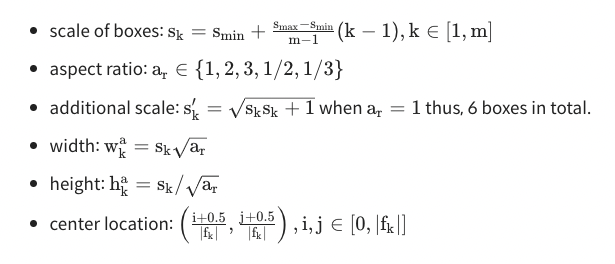

다양한 크기의 default box를 생성하기 위해 SSD는 다음과 같은 식을 사용한다.

feature map의 개수를 $m, S_{min}$을 0.2, $S_{max}$를 0.9라 하고 위 식에 넣으면 각 feature map당 서로 다른 6개의 scale값이 나온다.   
[0.2, 0.34, 0.48, 0.62, 0.76, 0.9]   
이 값은 각 feature map에서 default box의 크기가 입력 이미지의 너비와 높이에 비해 얼마나 큰지 보여준다.

여기서 aspect ratio를 토대로 default box의 너비와 높이를 구할 수 있게된다. 예를들어 k=3이라면 scale은 0.48이며 aspect ratio가 2라면 너비는 0.64, 높이는 0.34가 된다.   
논문에서는 1개의 box를 더 추가해 총 6개의 default box의 너비와 높이 값을 구한다.

입력 이미지에서 default box가 위치할 center location의 식에서 $f_k$는 k번째 feature map의 크기이다. 대략 예측되는 상자가 정사각형이나 가로로 조금 길쭉한 상자, 세로로 조금 길쭉한 상자이기 때문에 2:3 비율로 임의 설정해도 학습이 잘 된다.   
하지만 가로만 엄청 긴 특이한 경우, 위의 비율로 정하면 threshold를 0.5로 했을 때 학습이 되지 않는다. 따라서 학습할 이미지에 따라 aspect ratio를 조정해야한다.   
임의로 정하는 것은 비효율적이라 KNN과 같은 알고리즘을 활용하면 좋은 결과가 나올 것이다.

![](https://d3s0tskafalll9.cloudfront.net/media/images/seukeurinsyas_2021-11-09_18-12-02.max-800x600.png)

이렇게 구한 중심점 좌표에 원래 입력 이미지의 크기를 곱해 중심점을 구하고, 각 중심점마다 default box를 그릴 수 있게 된다.

# 13-10. SSD(2) SSD의 Loss와 성능

### Matching strategy
학습 전에 grdoun truth와 default box의 jaccard overlab(IoU)이 0.5 이상인 것을 미리 매칭시켜 positive sample로 설정한다. IoU가 0.5 이상인 default box를 모두 사용하면 학습 문제를 단순화 시켜 더 높은 성능을 가져올 수 있다.

### SSD Loss function


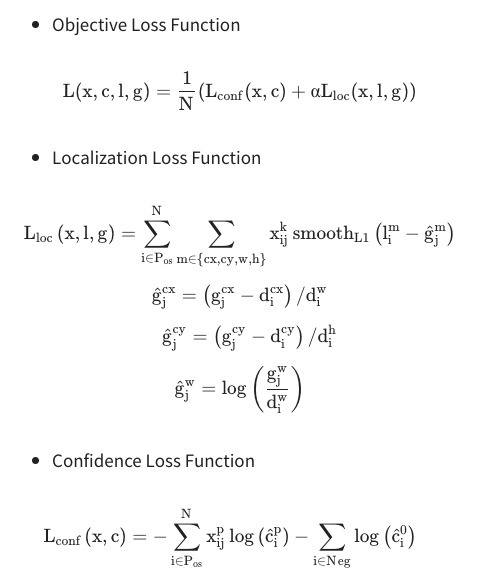

SSD Loss function에 들어가는 식이다. 용어들을 정리해보자.

- $x_{ij}^p$: category p에 대한 i번째 Default box와 j번째 ground truth box의 물체 인식 지표이다. 0.5 이상이면 1, 미만이면 0으로 정의된다.
- $N$: 매칭된 Default box의 수, N이 0이면 loss는 0이다.
- $l$: Predicted box
- $g$: ground truth box
- $d$: default bounding box
- $cx, cy$: 해당 box의 중심점 좌표
- $w, h$: 해당 box의 너비, 높이
- $\alpha$: 교차 검증으로 얻어진 값, 1으로 설정되어 있다.

### Objective Loss Function
전체 loss는 각 클래스 별로 예측한 값과 실제 값 사이의 차이인 $L_{conf}$와 bounding box regression 예측값과 실제값 사이의 차이인 $L_{loc}$을 더한 값이다.

### Localization Loss Function
예측된 박스 $l$과 ground truth box $g$ 파라미터 사이의 Smooth L1 loss, 즉 bounding box regression loss이다.   
$\hat{g}_j$는 예측해야할 bounding box의 중심점 좌표, 너비와 높이를 의미한다. x, y 좌표 값은 절대값이므로 예측값과 실제 값 사이의 차를 default 박스의 너비 혹은 높이로 나누어 0과 1 사이로 정규화 시켯다. 너비와 높이의 경우엔 로그를 씌워준다.

### Confidence Loss Function
여러 클래스의 confidence에 대한 softmax loss로 cross entropy loss와 비슷하다.   
매칭된 positive 클래스르 나타내는 값은 $c_i^p$이고, 그 매칭된 클래스에 softmax를 취해준다.   
매칭되지 않은 negative class를 예측하는 값은 $\hat{c}_i^0$이고 배경이면 1, 아니면 0의 값을 가진다. 즉 최종 예측된 클래스 점수는 예측할 클래스 + 배경 클래스를 나타내는 지표가 된다.

### Hard negative mining
대부분의 default box가 배경이기 때문에 $x_{ij}^p$이 0인 경우가 많다. 따라서 마지막 class의 loss 부분은 default box를 high confidence 순으로 정렬해 상위만 가져다 써서 positive와 negative 비율을 1:3으로 정해 출력한다.   
이렇게 하면 최적화 속도가 빨라지고 안정적으로 학습된다고 한다.

### SSD의 성능
![](https://d3s0tskafalll9.cloudfront.net/media/images/seukeurinsyas_2021-11-09_15-10-08.max-800x600.png)

Faster R-CNN보다 성능이 조금 낮지만 속도는 빠르고, YOLO보다 성능이 높고 속도는 느리다.   
SSD가 속도와 정확성을 동시에 잡자는 목표를 갖고 있음을 생각하면 괜찮은 지표이다.

![](https://d3s0tskafalll9.cloudfront.net/media/images/seukeurinsyas_2021-11-09_15-10-17.max-800x600.png)

YOLO가 작은 물체를 잘 찾아내지 못하는 문제가 있었는데, SSD는 어느정도 해결했다. YOLO v2보다 성능이 더 좋은걸 확인할 수 있다.

### FCOS
[FCOS:Fully convolutional One stage Object Detection](https://arxiv.org/pdf/1904.01355.pdf)은 기존의 anchor box 기반에서 벗어나 pixelwise로 예측하는 FCOS를 제안했다.   
anchor box를 사용하면서 생기는 학습 계산량 증가, 하이퍼파라미터에 민감한 성능 등을 해결하면서도 좋은 성능을 보인다.
- ["FCOS", One shot Anchor - Free Object Detection](https://blog.naver.com/jinyuri303/221876480557)

# 13-11. Face Detection을 위한 모델들

one stage detection의 대표적인 YOLO, SSD에 대해 살펴봤다.   

SSD 이후로 face detection 모델이 지속적으로 발표됐다.   
SOTA Face Detection 모델을 중심으로 간단히 살펴보자.

### TinaFace
![](https://d3s0tskafalll9.cloudfront.net/media/images/seukeurinsyas_2021-11-10_12-55-35.max-800x600.png)

발표 논문에서 Face detection과 object detection이 다르지 않다는 점을 지적하면서, object detection에서 사용한 기법을 사용해 단순하지만 좋은 성능을 보이는 모델인 TinaFace를 발표했다.   
백본으로 ResNet50를 사용했고 기존에 존재한 모듈(Feature Pyramid Network, Inception block, FCN 등)을 활용해 만들었다.

### RetinaFace
![](https://d3s0tskafalll9.cloudfront.net/media/original_images/seukeurinsyas_2021-11-10_14-25-09.png)

1-stage face detector로 다양한 얼굴 크기에 대해 pixel wise face localization을 수행했다.   
이를 위해 기존의 box classification과 regression 브랜치와 함께 extra supervised and slef supervised multi task learning을 했다고 한다.   
그 결과 그림에서 볼 수 잇듯이 face score, face box, 5개의 얼굴 랜드마크, 3D face vertices를 볼 수 있다.

### DSFD
Feature Enhance Module(FEM), Progressive Anchor Loss(PAL), Improved Anchor Matching(IAM)이라는 기법을 사용해 성능을 높인 모델이다.   
언습한 세 기법이 two stream으로 디자인 되어 dual shot face detector라는 이름이 붙었다고 한다.

### S3FD
하나의 deep neural network를 사용해 다양한 얼굴 크기에 대해 face detection을 수행하며, 특히 작은 얼굴을 잘 찾는 모델이다.   
다양한 크기의 얼굴을 잘 찾기 위해 layer의 넓은 범위에 anchor를 바둑판 형식으로 배열하였고, anchor 크기도 새롭게 디자인했다고 한다.   
그 외에 작을 얼굴을 잘 찾기위해 다양한 기법을 사용했다.